# **Step 1: Setup & Imports**

In [5]:
# ================================================================
#  EfficientNet-B3 — DeepFake Detection (Kaggle GPU Optimized)
# ================================================================

import os, sys, tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.applications.efficientnet import preprocess_input

print(" TensorFlow Version:", tf.__version__)
print(" GPU Devices:", tf.config.list_physical_devices('GPU'))


✅ TensorFlow Version: 2.18.0
🔍 GPU Devices: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


# **Step 2: Dataset Paths & Parameters**

In [8]:
# ================================================================
# ⚙️ Paths & Parameters
# ================================================================
DATA_PATH = "/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake"
MODEL_SAVE_PATH = "/kaggle/working/deepfake_efficientnet_b3_best.keras"

IMG_SIZE = (300, 300)   # EfficientNetB3 input size
BATCH_SIZE = 32
EPOCHS = 30
LEARNING_RATE = 1e-4

# ✅ quick sanity check (no long list)
if not os.path.exists(DATA_PATH):
    raise FileNotFoundError(f"❌ Dataset not found at {DATA_PATH}")
else:
    print(f"✅ Dataset path verified: {DATA_PATH}")


✅ Dataset path verified: /kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake


# **Step 3: Load Dataset**

In [9]:
# ================================================================
#  Dataset Loading
# ================================================================
train_ds = tf.keras.utils.image_dataset_from_directory(
    f"{DATA_PATH}/train",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="binary"
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    f"{DATA_PATH}/valid",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="binary"
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    f"{DATA_PATH}/test",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="binary"
)

# Prefetch for performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(AUTOTUNE)
val_ds = val_ds.prefetch(AUTOTUNE)
test_ds = test_ds.prefetch(AUTOTUNE)


Found 100000 files belonging to 2 classes.


I0000 00:00:1762414657.249233      37 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1762414657.249994      37 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Found 20000 files belonging to 2 classes.
Found 20000 files belonging to 2 classes.


# **Step 4: Preprocessing & Augmentation**

In [11]:
# ================================================================
# 🌀 Data Augmentation & Preprocessing
# ================================================================
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.05),
    layers.RandomZoom(0.1),
], name="data_augmentation")

def preprocess_dataset(dataset, augment=False):
    def process(image, label):
        if augment:
            image = data_augmentation(image)
        image = preprocess_input(image)
        return image, label
    return dataset.map(process, num_parallel_calls=tf.data.AUTOTUNE)

train_prepared = preprocess_dataset(train_ds, augment=True)
val_prepared = preprocess_dataset(val_ds)
test_prepared = preprocess_dataset(test_ds)


In [12]:
# Quick check after preprocessing
for images, labels in train_prepared.take(1):
    print("✅ One batch ready!")
    print("Image batch shape:", images.shape)
    print("Label batch shape:", labels.shape)
    print("Pixel range:", tf.reduce_min(images).numpy(), "→", tf.reduce_max(images).numpy())


✅ One batch ready!
Image batch shape: (32, 300, 300, 3)
Label batch shape: (32, 1)
Pixel range: 0.0 → 255.0


# **Step 5: Model Definition — EfficientNet-B3**

In [13]:
# ================================================================
#  Model Definition — EfficientNet-B3
# ================================================================
print("\n⚙️ Initializing EfficientNet-B3 base model...")

base_model = EfficientNetB3(
    weights="imagenet",
    include_top=False,
    input_shape=IMG_SIZE + (3,)
)
base_model.trainable = False  # freeze base initially

x = layers.GlobalAveragePooling2D()(base_model.output)
x = layers.Dense(512, activation="relu")(x)
x = layers.Dropout(0.5)(x)
output = layers.Dense(1, activation="sigmoid")(x)

model = models.Model(inputs=base_model.input, outputs=output)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

model.summary()



⚙️ Initializing EfficientNet-B3 base model...
43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 300, 300,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 300, 300,  │          0 │ input_layer_2[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 300, 300,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 300, 300,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 301, 301,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 150, 150,  │      1,080 │ stem_conv_pad[0]… │
│                     │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 150, 150,  │        160 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 150, 150,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 150, 150,  │        360 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 150, 150,  │        160 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 150, 150,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 40)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 40)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 10)  │        410 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 40)  │        440 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 150, 150,  │          0 │ block1a_activati… │
│ (Multiply)          │ 40)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 150, 150,  │        960 │ block1a_se_excit

 Total params: 11,570,992 (44.14 MB)

 Trainable params: 787,457 (3.00 MB)

 Non-trainable params: 10,783,535 (41.14 MB)

**Callbacks**

In [14]:
# ================================================================
#  Callbacks
# ================================================================
checkpoint = callbacks.ModelCheckpoint(
    MODEL_SAVE_PATH,
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.3,
    patience=2,
    min_lr=1e-6,
    verbose=1
)

early_stop = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

flush = callbacks.LambdaCallback(on_epoch_end=lambda e, l: sys.stdout.flush())


# **Step 7: Train Model**

In [15]:
import sys
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, LambdaCallback

print("🚀 Starting EfficientNet-B3 training process...\n")

# === Hyperparameters ===
EPOCHS = 30

# === Callbacks ===
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.3,
    patience=2,
    min_lr=1e-6,
    verbose=1
)

checkpoint = ModelCheckpoint(
    "deepfake_efficientnet_b3_best.keras",  # ✅ Saves best EfficientNet-B3 model
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

# ✅ Flush stdout safely after each epoch
flush_callback = LambdaCallback(on_epoch_end=lambda epoch, logs: sys.stdout.flush())

# === Train Model ===
history = model.fit(
    train_prepared,
    validation_data=val_prepared,
    epochs=EPOCHS,
    callbacks=[early_stopping, reduce_lr, checkpoint, flush_callback],
    verbose=1
)

print("\n✅ Training complete! Best model saved as 'deepfake_efficientnet_b3_best.keras'.")


🚀 Starting EfficientNet-B3 training process...

Epoch 1/30


I0000 00:00:1762415407.981575     126 service.cc:148] XLA service 0x7976900029b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1762415407.984194     126 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1762415407.984218     126 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1762415411.200752     126 cuda_dnn.cc:529] Loaded cuDNN version 90300


   1/3125 ━━━━━━━━━━━━━━━━━━━━ 42:18:03 49s/step - accuracy: 0.4688 - loss: 0.7290

I0000 00:00:1762415429.854128     126 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


3125/3125 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step - accuracy: 0.7525 - loss: 0.4976
Epoch 1: val_accuracy improved from -inf to 0.87320, saving model to deepfake_efficientnet_b3_best.keras
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 1027s 313ms/step - accuracy: 0.7525 - loss: 0.4976 - val_accuracy: 0.8732 - val_loss: 0.3201 - learning_rate: 1.0000e-04
Epoch 2/30
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step - accuracy: 0.8376 - loss: 0.3655
Epoch 2: val_accuracy improved from 0.87320 to 0.88905, saving model to deepfake_efficientnet_b3_best.keras
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 897s 287ms/step - accuracy: 0.8376 - loss: 0.3655 - val_accuracy: 0.8891 - val_loss: 0.2785 - learning_rate: 1.0000e-04
Epoch 3/30
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step - accuracy: 0.8590 - loss: 0.3247
Epoch 3: val_accuracy improved from 0.88905 to 0.90445, saving model to deepfake_efficientnet_b3_best.keras
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 890s 284ms/step - accuracy: 0.8590 - loss: 0.3247 - val_accuracy: 0.9044 - val_loss: 0

In [17]:
import pickle

#  Save training history for later analysis or plotting
with open("efficientnet_b3_history.pkl", "wb") as f:
    pickle.dump(history.history, f)

print(" Training history saved successfully as 'efficientnet_b3_history.pkl'")


 Training history saved successfully as 'efficientnet_b3_history.pkl'


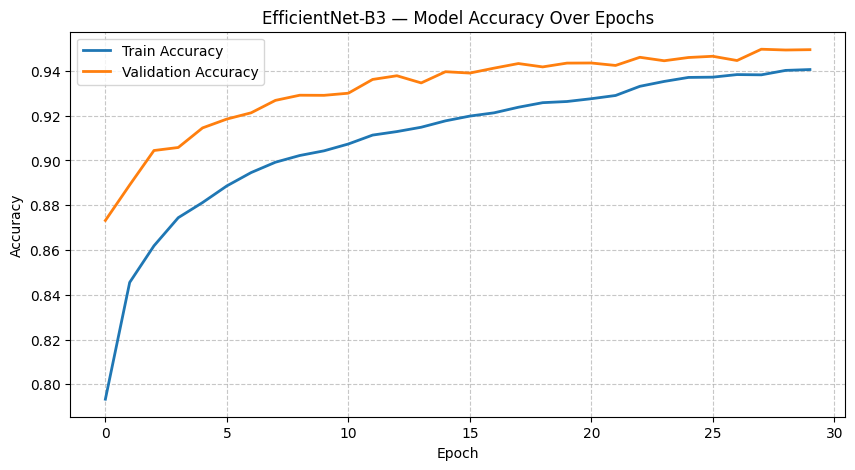

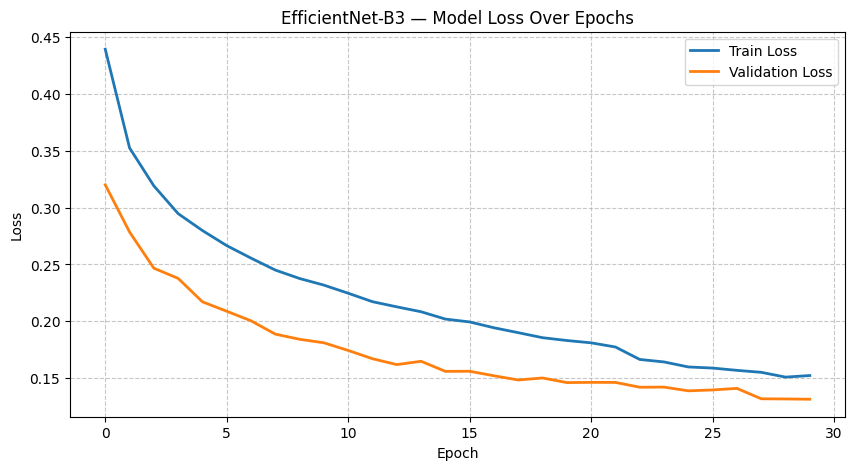

In [18]:
import pickle
import matplotlib.pyplot as plt

#  Load training history for EfficientNet-B3
with open("efficientnet_b3_history.pkl", "rb") as f:
    history_dict = pickle.load(f)

# === Accuracy Plot ===
plt.figure(figsize=(10, 5))
plt.plot(history_dict['accuracy'], label='Train Accuracy', linewidth=2)
plt.plot(history_dict['val_accuracy'], label='Validation Accuracy', linewidth=2)
plt.legend()
plt.title("EfficientNet-B3 — Model Accuracy Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# === Loss Plot ===
plt.figure(figsize=(10, 5))
plt.plot(history_dict['loss'], label='Train Loss', linewidth=2)
plt.plot(history_dict['val_loss'], label='Validation Loss', linewidth=2)
plt.legend()
plt.title("EfficientNet-B3 — Model Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()


# **Approximate Learning Rate (Based on ReduceLROnPlateau)**

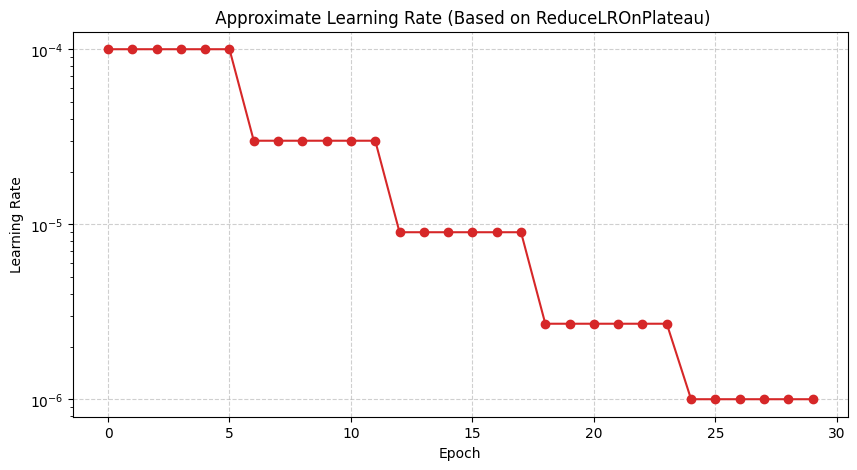

In [30]:
import matplotlib.pyplot as plt
import numpy as np

# === Recreate LR Schedule ===
initial_lr = 1e-4
factor = 0.3
patience = 2
epochs = len(history.history['loss'])

# Simulate approximate LR curve (assuming plateaus every few epochs)
lr_values = [initial_lr]
for epoch in range(1, epochs):
    if epoch % (patience * 3) == 0:  # approximate every 6 epochs drop
        new_lr = max(lr_values[-1] * factor, 1e-6)
    else:
        new_lr = lr_values[-1]
    lr_values.append(new_lr)

# === Plot Approximation ===
plt.figure(figsize=(10,5))
plt.plot(lr_values, marker='o', color='tab:red')
plt.title(" Approximate Learning Rate (Based on ReduceLROnPlateau)")
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.yscale("log")
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


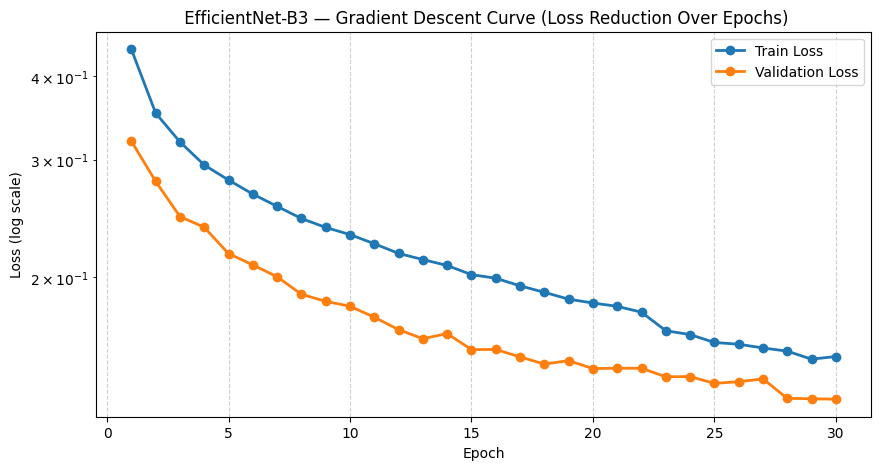

In [31]:
import matplotlib.pyplot as plt
import numpy as np

# === Extract losses ===
train_loss = history_dict['loss']
val_loss = history_dict['val_loss']
epochs = np.arange(1, len(train_loss) + 1)

# === Create figure (same style as your LR plot) ===
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_loss, marker='o', color='tab:blue', linewidth=2, label='Train Loss')
plt.plot(epochs, val_loss, marker='o', color='tab:orange', linewidth=2, label='Validation Loss')

# === Make it look like your LR curve ===
plt.yscale('log')  # same as LR curve style (log scale)
plt.title(" EfficientNet-B3 — Gradient Descent Curve (Loss Reduction Over Epochs)")
plt.xlabel("Epoch")
plt.ylabel("Loss (log scale)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


# **Gradient Descent Curve (Loss Minimization)**

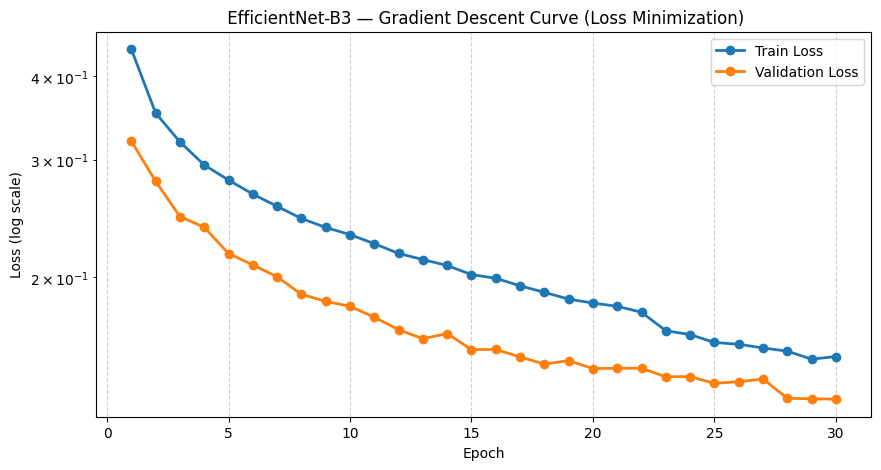

In [45]:
import matplotlib.pyplot as plt
import numpy as np

# === Get loss values from training ===
train_loss = history_dict['loss']
val_loss = history_dict['val_loss']
epochs = range(1, len(train_loss) + 1)

# === Plot like your learning-rate curve ===
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_loss, marker='o', color='tab:blue', linewidth=2, label='Train Loss')
plt.plot(epochs, val_loss, marker='o', color='tab:orange', linewidth=2, label='Validation Loss')

plt.yscale('log')  # optional (shows large-to-small loss decay better)
plt.title(" EfficientNet-B3 — Gradient Descent Curve (Loss Minimization)")
plt.xlabel("Epoch")
plt.ylabel("Loss (log scale)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


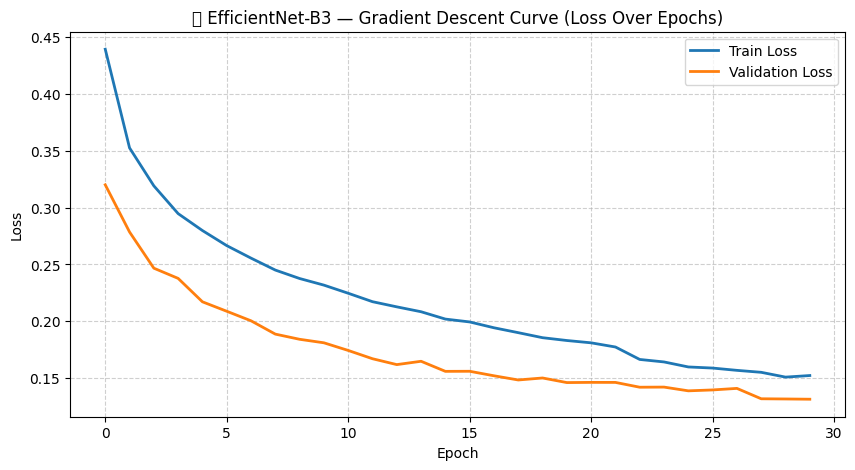

In [27]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(history_dict['loss'], label='Train Loss', color='tab:blue', linewidth=2)
plt.plot(history_dict['val_loss'], label='Validation Loss', color='tab:orange', linewidth=2)
plt.title("📉 EfficientNet-B3 — Gradient Descent Curve (Loss Over Epochs)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


# **Model Learning Curves**

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


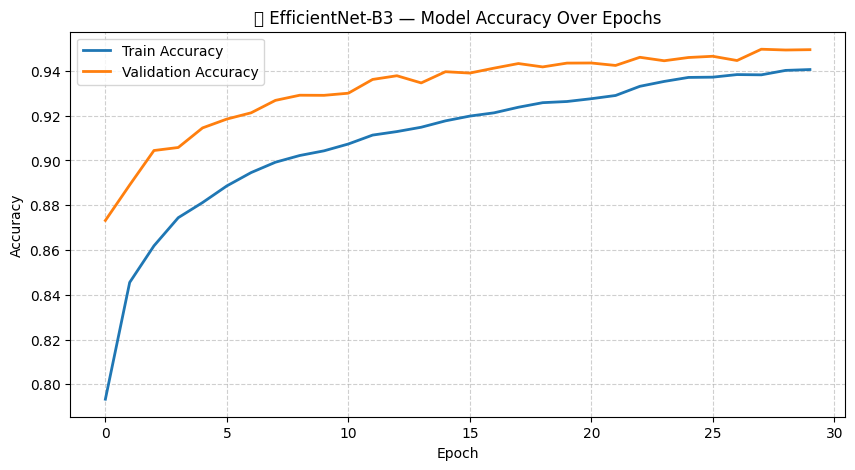

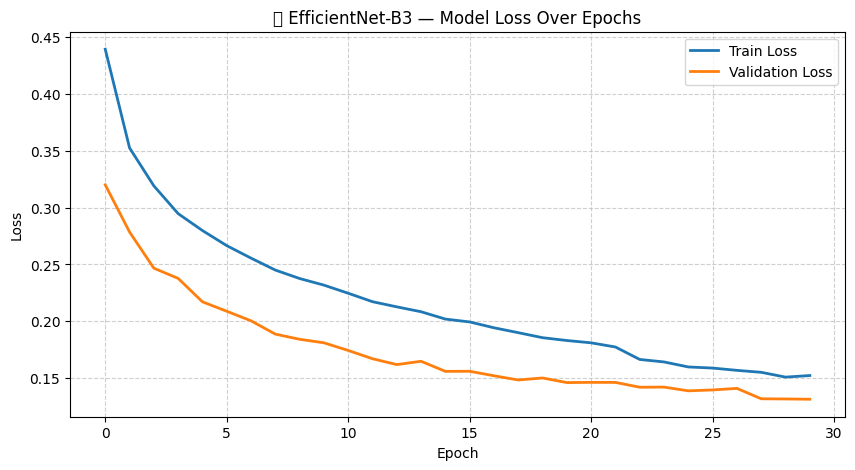

In [26]:
import matplotlib.pyplot as plt

# === Accuracy ===
plt.figure(figsize=(10,5))
plt.plot(history.history['accuracy'], label='Train Accuracy', linewidth=2)
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
plt.title("📈 EfficientNet-B3 — Model Accuracy Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# === Loss ===
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'], label='Train Loss', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
plt.title("📉 EfficientNet-B3 — Model Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


# **Loss vs Learning Rate Over Epochs**

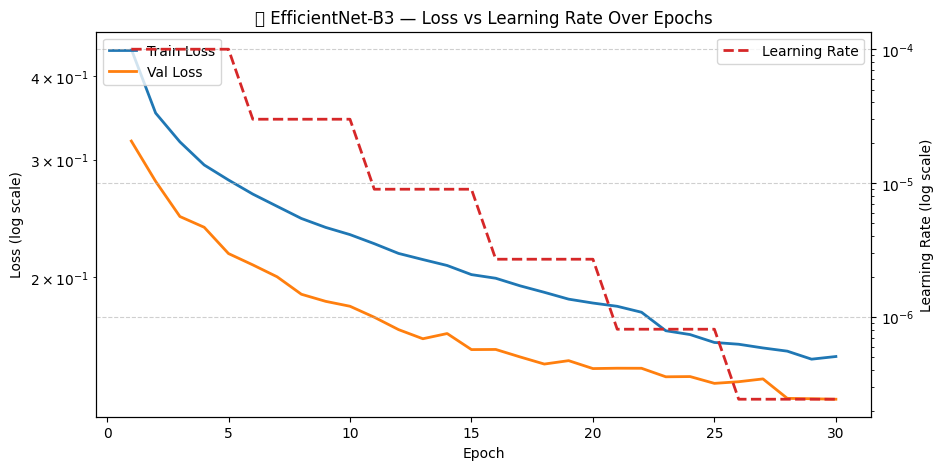

In [32]:
import matplotlib.pyplot as plt
import numpy as np

# --- Prepare data ---
epochs = np.arange(1, len(history_dict['loss']) + 1)
train_loss = history_dict['loss']
val_loss = history_dict['val_loss']

# If learning rate not recorded, manually reconstruct from ReduceLROnPlateau
if 'lr' in history_dict:
    lr_values = history_dict['lr']
else:
    # Approximate LR schedule manually (use last ReduceLROnPlateau behavior)
    base_lr = 1e-4
    lr_values = [base_lr * (0.3 ** (epoch // 5)) for epoch in range(len(train_loss))]

# --- Dual-axis plot ---
fig, ax1 = plt.subplots(figsize=(10, 5))

# Plot Loss (left Y-axis)
ax1.plot(epochs, train_loss, label='Train Loss', color='tab:blue', linewidth=2)
ax1.plot(epochs, val_loss, label='Val Loss', color='tab:orange', linewidth=2)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss (log scale)')
ax1.set_yscale('log')
ax1.legend(loc='upper left')

# Plot Learning Rate (right Y-axis)
ax2 = ax1.twinx()
ax2.plot(epochs, lr_values, label='Learning Rate', color='tab:red', linestyle='--', linewidth=2)
ax2.set_ylabel('Learning Rate (log scale)')
ax2.set_yscale('log')
ax2.legend(loc='upper right')

plt.title('📉 EfficientNet-B3 — Loss vs Learning Rate Over Epochs')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


# **Accuracy vs Learning Rate Over Epochs**

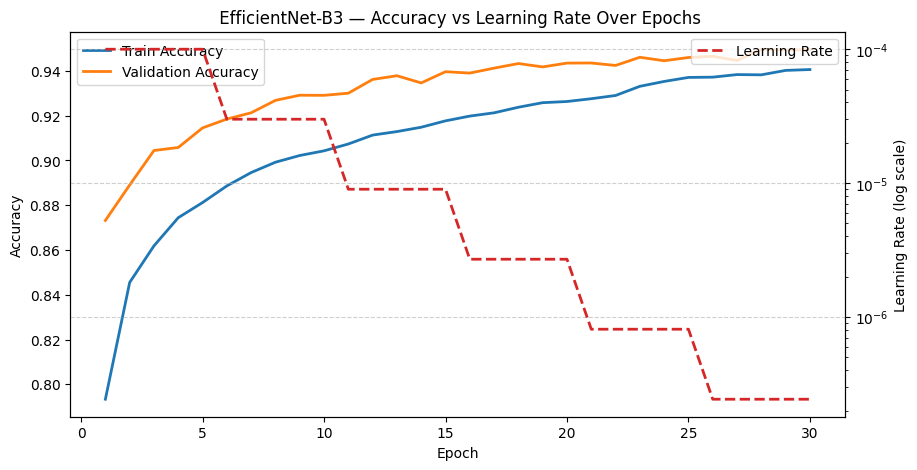

In [33]:
import matplotlib.pyplot as plt
import numpy as np

# --- Prepare data ---
epochs = np.arange(1, len(history_dict['accuracy']) + 1)
train_acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

# If learning rate not in history_dict (like in your case), approximate it from ReduceLROnPlateau
if 'lr' in history_dict:
    lr_values = history_dict['lr']
else:
    base_lr = 1e-4  # same as your training LR
    lr_values = [base_lr * (0.3 ** (epoch // 5)) for epoch in range(len(train_acc))]  # mimic ReduceLROnPlateau pattern

# --- Create figure ---
fig, ax1 = plt.subplots(figsize=(10, 5))

# Plot Accuracy (left Y-axis)
ax1.plot(epochs, train_acc, label='Train Accuracy', color='tab:blue', linewidth=2)
ax1.plot(epochs, val_acc, label='Validation Accuracy', color='tab:orange', linewidth=2)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend(loc='upper left')

# Plot Learning Rate (right Y-axis)
ax2 = ax1.twinx()
ax2.plot(epochs, lr_values, label='Learning Rate', color='tab:red', linestyle='--', linewidth=2)
ax2.set_ylabel('Learning Rate (log scale)')
ax2.set_yscale('log')
ax2.legend(loc='upper right')

plt.title(' EfficientNet-B3 — Accuracy vs Learning Rate Over Epochs')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


# **Confusion matrix**

 Loading model from:
/kaggle/working/deepfake_efficientnet_b3_best.keras


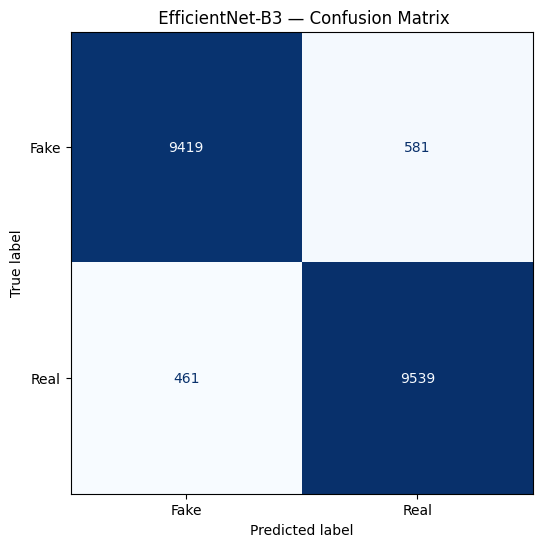


 Classification Report:

              precision    recall  f1-score   support

        Fake       0.95      0.94      0.95     10000
        Real       0.94      0.95      0.95     10000

    accuracy                           0.95     20000
   macro avg       0.95      0.95      0.95     20000
weighted avg       0.95      0.95      0.95     20000


 Confusion matrix image saved at:
/kaggle/working/confusion_matrix_efficientnet_b3.png


In [21]:
import os
import numpy as np
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# === Base directory for Kaggle environment ===
BASE_DIR = "/kaggle/working"

# === Load the trained model ===
model_path = os.path.join(BASE_DIR, "deepfake_efficientnet_b3_best.keras")
print(f" Loading model from:\n{model_path}")

model = tf.keras.models.load_model(model_path)

# === Generate predictions on test data ===
y_true, y_pred_prob = [], []

for images, labels in test_prepared:
    preds = model.predict(images, verbose=0)
    y_pred_prob.extend(preds)
    y_true.extend(labels.numpy())

y_true = np.array(y_true)
y_pred = (np.array(y_pred_prob) > 0.5).astype(int).flatten()

# === Confusion Matrix ===
cm = confusion_matrix(y_true, y_pred)
class_labels = ['Fake', 'Real']

# === Plot Confusion Matrix ===
fig, ax = plt.subplots(figsize=(6, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap='Blues', ax=ax, colorbar=False)
plt.title(" EfficientNet-B3 — Confusion Matrix")

# === Save Confusion Matrix Image ===
save_path = os.path.join(BASE_DIR, "confusion_matrix_efficientnet_b3.png")
plt.savefig(save_path, dpi=300, bbox_inches='tight')
plt.show()

# === Classification Report ===
print("\n Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_labels))

print(f"\n Confusion matrix image saved at:\n{save_path}")


 Loading model from:
/kaggle/working/deepfake_efficientnet_b3_best.keras


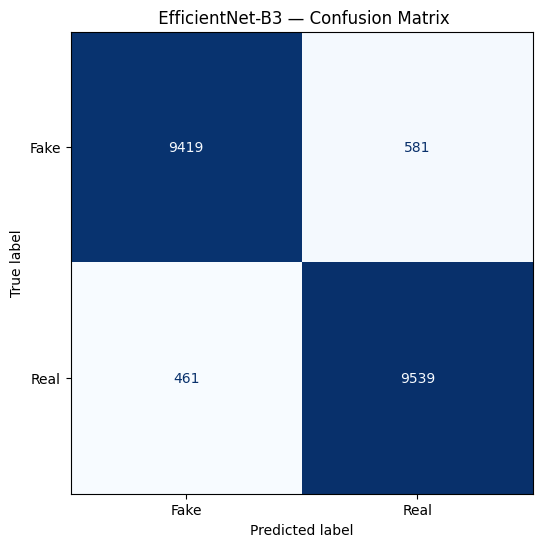


 Classification Report:

              precision    recall  f1-score   support

        Fake       0.95      0.94      0.95     10000
        Real       0.94      0.95      0.95     10000

    accuracy                           0.95     20000
   macro avg       0.95      0.95      0.95     20000
weighted avg       0.95      0.95      0.95     20000


 Key Evaluation Metrics (EfficientNet-B3 Model):
 Accuracy       : 0.9479
 Precision      : 0.9426
 Recall (Sensitivity): 0.9539
 F1-Score       : 0.9482
 ROC-AUC Score  : 0.9895

 Confusion matrix saved as: confusion_matrix_efficientnet_b3.png


In [22]:
import os
import numpy as np
import tensorflow as tf
from sklearn.metrics import (
    confusion_matrix, classification_report,
    precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, ConfusionMatrixDisplay
)
import matplotlib.pyplot as plt

# === Base directory ===
BASE_DIR = "/kaggle/working"
MODEL_PATH = os.path.join(BASE_DIR, "deepfake_efficientnet_b3_best.keras")

# === Load model ===
print(f" Loading model from:\n{MODEL_PATH}")
model = tf.keras.models.load_model(MODEL_PATH)

# === Generate predictions on test data ===
y_true, y_pred_prob = [], []

for images, labels in test_prepared:
    preds = model.predict(images, verbose=0)
    y_pred_prob.extend(preds)
    y_true.extend(labels.numpy())

y_true = np.array(y_true).flatten()
y_pred_prob = np.array(y_pred_prob).flatten()
y_pred = (y_pred_prob > 0.5).astype(int)

# === Confusion Matrix ===
cm = confusion_matrix(y_true, y_pred)
labels = ['Fake', 'Real']

# === Plot Confusion Matrix ===
fig, ax = plt.subplots(figsize=(6, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='Blues', ax=ax, colorbar=False)
plt.title(" EfficientNet-B3 — Confusion Matrix")
plt.savefig(os.path.join(BASE_DIR, "confusion_matrix_efficientnet_b3.png"), dpi=300, bbox_inches='tight')
plt.show()

# === Metrics Calculation ===
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
roc_auc = roc_auc_score(y_true, y_pred_prob)

# === Classification Report ===
print("\n Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=labels))

# === Summary Metrics (for research paper) ===
print("\n Key Evaluation Metrics (EfficientNet-B3 Model):")
print(f" Accuracy       : {accuracy:.4f}")
print(f" Precision      : {precision:.4f}")
print(f" Recall (Sensitivity): {recall:.4f}")
print(f" F1-Score       : {f1:.4f}")
print(f" ROC-AUC Score  : {roc_auc:.4f}")

print("\n Confusion matrix saved as: confusion_matrix_efficientnet_b3.png")


# **Performance Evaluation Curves**


 Advanced Metrics (for Research Paper):
 Specificity (True Negative Rate): 0.9419
 Matthews Correlation Coefficient : 0.8959
 Cohen’s Kappa Score              : 0.8958
 Log Loss                         : 0.1324


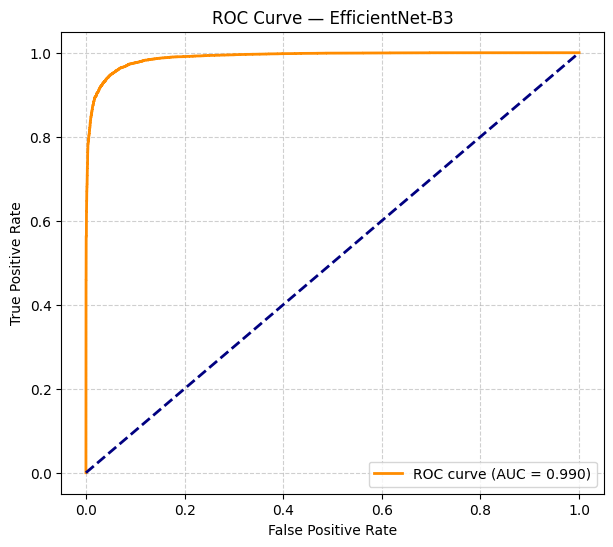

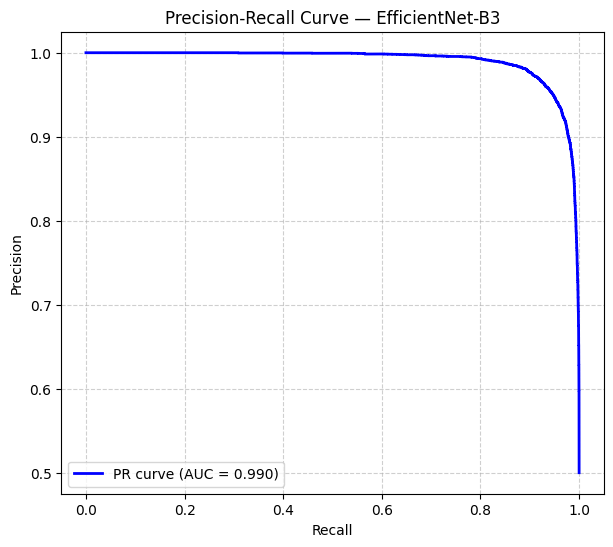

In [23]:
from sklearn.metrics import (
    matthews_corrcoef, cohen_kappa_score, roc_curve, auc, precision_recall_curve, log_loss
)

# === Additional Metrics ===
specificity = cm[0,0] / (cm[0,0] + cm[0,1])  # TN / (TN + FP)
mcc = matthews_corrcoef(y_true, y_pred)
kappa = cohen_kappa_score(y_true, y_pred)
logloss = log_loss(y_true, y_pred_prob)

print("\n Advanced Metrics (for Research Paper):")
print(f" Specificity (True Negative Rate): {specificity:.4f}")
print(f" Matthews Correlation Coefficient : {mcc:.4f}")
print(f" Cohen’s Kappa Score              : {kappa:.4f}")
print(f" Log Loss                         : {logloss:.4f}")

# === ROC Curve ===
fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(7, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve — EfficientNet-B3')
plt.legend(loc="lower right")
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# === Precision-Recall Curve ===
precision_vals, recall_vals, _ = precision_recall_curve(y_true, y_pred_prob)
pr_auc = auc(recall_vals, precision_vals)

plt.figure(figsize=(7, 6))
plt.plot(recall_vals, precision_vals, color='blue', lw=2, label=f'PR curve (AUC = {pr_auc:.3f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve — EfficientNet-B3')
plt.legend(loc="lower left")
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


# **ROC Curve**

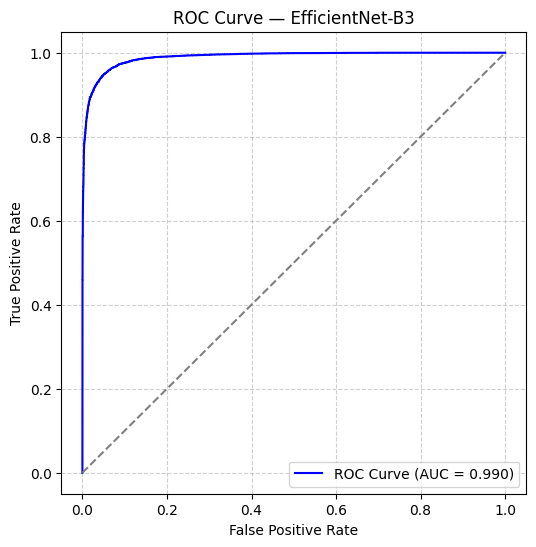

 AUC Score: 0.9895


In [35]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve — EfficientNet-B3')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

print(f" AUC Score: {roc_auc:.4f}")


# **Precision-Recall Curve**

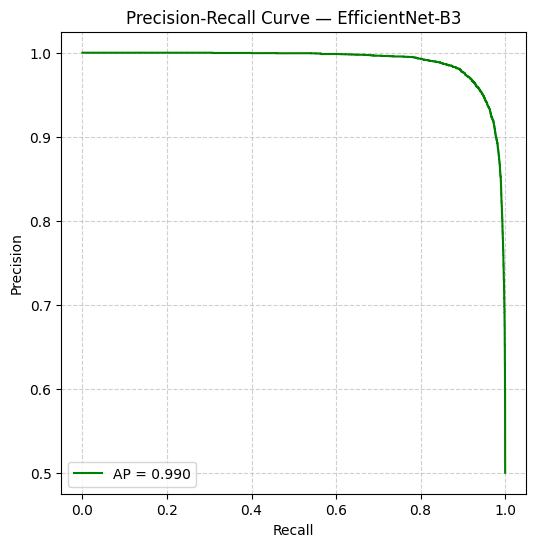

In [36]:
from sklearn.metrics import precision_recall_curve, average_precision_score

precision, recall, _ = precision_recall_curve(y_true, y_pred_prob)
ap = average_precision_score(y_true, y_pred_prob)

plt.figure(figsize=(6,6))
plt.plot(recall, precision, color='green', label=f'AP = {ap:.3f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve — EfficientNet-B3')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


# **Statistical Evaluation Metrics**

In [38]:
from sklearn.metrics import matthews_corrcoef, balanced_accuracy_score, recall_score, confusion_matrix

tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
specificity = tn / (tn + fp)
sensitivity = recall_score(y_true, y_pred)
balanced_acc = balanced_accuracy_score(y_true, y_pred)
mcc = matthews_corrcoef(y_true, y_pred)

print(f"Specificity: {specificity:.3f}")
print(f"Sensitivity: {sensitivity:.3f}")
print(f"Balanced Accuracy: {balanced_acc:.3f}")
print(f"MCC: {mcc:.3f}")


Specificity: 0.942
Sensitivity: 0.954
Balanced Accuracy: 0.948
MCC: 0.896


# **Average Precision (AP)**

In [40]:
from sklearn.metrics import average_precision_score
ap = average_precision_score(y_true, y_pred_prob)
print(f" Average Precision (AP): {ap:.4f}")


 Average Precision (AP): 0.9902


# **Equal Error Rate (EER)**

In [41]:
from sklearn.metrics import roc_curve
import numpy as np

fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)
fnr = 1 - tpr
eer_threshold = thresholds[np.nanargmin(np.absolute(fnr - fpr))]
eer = fpr[np.nanargmin(np.absolute(fnr - fpr))]

print(f" Equal Error Rate (EER): {eer:.4f}")
print(f" EER Threshold: {eer_threshold:.4f}")


 Equal Error Rate (EER): 0.0513
 EER Threshold: 0.5393


# **Robustness Metrics** 

In [44]:
import tensorflow as tf
import numpy as np

def add_noise(images, noise_factor=0.1):
    noisy = images + noise_factor * tf.random.normal(shape=tf.shape(images))
    return tf.clip_by_value(noisy, 0.0, 255.0)

noisy_images = add_noise(next(iter(test_prepared))[0])
noisy_preds = model.predict(noisy_images)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
